In [ ]:
!wget https://raw.githubusercontent.com/openforcefield/2023-workshop-vignettes/master/colab_setup.ipynb
%run colab_setup.ipynb

# OpenFF Code

In [ ]:
from openff.toolkit import Molecule, Topology, ForceField
orig_ligand = Molecule.from_file('inputs/PT2385.sdf')
orig_top = Topology.from_pdb('inputs/solvated_complex.pdb',
                       unique_molecules=[orig_ligand]
                       )
ff = ForceField("openff-2.0.0.offxml", "ff14sb_off_impropers_0.0.3.offxml")

In [ ]:
orig_ligand.visualize(backend="rdkit")

# RDKit Code

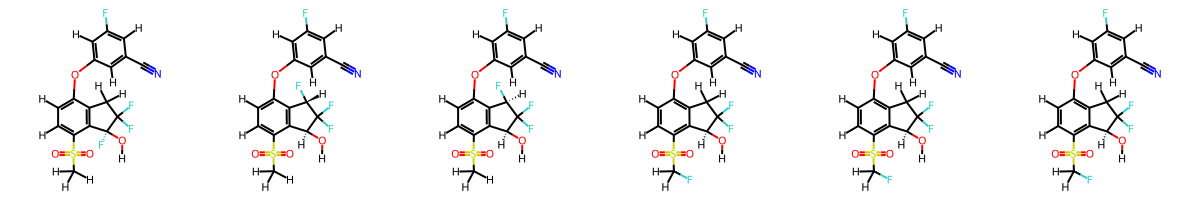

In [3]:
# Use RDKit's reaction handling to try mutating each aliphatic C-H bond to C-F
import rdkit
rdmol = orig_ligand.to_rdkit()
rxn = rdkit.Chem.rdChemReactions.ReactionFromSmarts(
    '[C:1][H:2] >> [C:1][F:2]'
)
products = rxn.RunReactants([rdmol])
sanitized_products = []
mols_for_drawing = []

for product in products:
    mol_copy = rdkit.Chem.Mol(product[0])
    rdkit.Chem.SanitizeMol(mol_copy, rdkit.Chem.SANITIZE_ALL)
    rdkit.Chem.AssignStereochemistryFrom3D(mol_copy)
    rdkit.Chem.Kekulize(mol_copy, clearAromaticFlags=True)
    rdkit.Chem.SetAromaticity(mol_copy, rdkit.Chem.AromaticityModel.AROMATICITY_MDL)
    sanitized_products.append(mol_copy)
    # Prepare molecules to be drawn as a grid image. 
    # I don't like the 3D projections so I remove the conformers here.
    mol_for_drawing = rdkit.Chem.Mol(mol_copy)
    rdkit.Chem.rdchem.Mol.RemoveAllConformers(mol_copy)
    mols_for_drawing.append(mol_copy)
    
rdkit.Chem.Draw.MolsToGridImage(mols_for_drawing, 
                               molsPerRow=6)


In [4]:
# Since some substitutions won't actually lead to a "new" molecule, filter by isomeric SMILES
unique_offmols = [orig_ligand]
seen_smiles = set()
for san_prod in sanitized_products:
    offmol = Molecule.from_rdkit(san_prod)
    smi = offmol.to_smiles()
    if smi not in seen_smiles:
        print(f"smiles is unique: {smi}")
        unique_offmols.append(offmol)
        seen_smiles.add(smi)
    else:
        print(f"smiles is not unique: {smi}")


smiles is unique: [H]c1c(c(c2c(c1Oc3c(c(c(c(c3[H])F)[H])C#N)[H])C(C([C@]2(O[H])F)(F)F)([H])[H])S(=O)(=O)C([H])([H])[H])[H]
smiles is unique: [H]c1c(c(c2c(c1Oc3c(c(c(c(c3[H])F)[H])C#N)[H])[C@](C([C@@]2([H])O[H])(F)F)([H])F)S(=O)(=O)C([H])([H])[H])[H]
smiles is unique: [H]c1c(c(c2c(c1Oc3c(c(c(c(c3[H])F)[H])C#N)[H])[C@@](C([C@@]2([H])O[H])(F)F)([H])F)S(=O)(=O)C([H])([H])[H])[H]
smiles is unique: [H]c1c(c(c2c(c1Oc3c(c(c(c(c3[H])F)[H])C#N)[H])C(C([C@@]2([H])O[H])(F)F)([H])[H])S(=O)(=O)C([H])([H])F)[H]
smiles is not unique: [H]c1c(c(c2c(c1Oc3c(c(c(c(c3[H])F)[H])C#N)[H])C(C([C@@]2([H])O[H])(F)F)([H])[H])S(=O)(=O)C([H])([H])F)[H]
smiles is not unique: [H]c1c(c(c2c(c1Oc3c(c(c(c(c3[H])F)[H])C#N)[H])C(C([C@@]2([H])O[H])(F)F)([H])[H])S(=O)(=O)C([H])([H])F)[H]


# OpenFF and OpenMM Code

In [ ]:
import openmm
from openff.units import Quantity, unit
from openmm import unit as openmm_unit

idx_to_sim = dict()
n_systems = len(unique_offmols)

for idx, unique_offmol in enumerate(unique_offmols):
    print(f"Making topology {idx+1}/{n_systems}")
    this_top = Topology.from_molecules([*orig_top.molecules][:-1] +
                                       [unique_offmol])
    this_top.box_vectors = orig_top.box_vectors
    pdb_filename = f"topology{idx+1}.pdb"
    this_top.to_file(pdb_filename)
    print(f"Parametrizing system {idx+1}/{n_systems}")
    sys = ff.create_openmm_system(this_top)
    # Construct and configure a Langevin integrator at 300 K with an appropriate friction constant and time-step
    integrator = openmm.LangevinIntegrator(
        300 * openmm_unit.kelvin,
        1 / openmm_unit.picosecond,
        0.002 * openmm_unit.picoseconds,
    )

    print(f"Minimizing system {idx+1}/{n_systems}")

    # Combine the topology, system, integrator and initial positions into a simulation
    simulation = openmm.app.Simulation(this_top.to_openmm(), sys, integrator)
    simulation.context.setPositions(this_top.get_positions().to_openmm())
    simulation.minimizeEnergy(
    tolerance=openmm_unit.Quantity(
        value=50.0, unit=openmm_unit.kilojoule_per_mole / openmm_unit.nanometer
    )
    )
    print(f"Simulating system {idx+1}/{n_systems}")

    # Add a reporter to record the structure every 50 steps
    traj_filename = f"trajectory_{idx+1}.dcd"
    dcd_reporter = openmm.app.DCDReporter(traj_filename, 50)
    simulation.reporters.append(dcd_reporter)
    simulation.context.setVelocitiesToTemperature(300 * openmm_unit.kelvin)
    simulation.runForClockTime(15 * openmm_unit.second)
    idx_to_sim[idx+1] = {"topology": this_top,
                         "pdb_filename": pdb_filename,
                         "system": sys,
                         "simulation": simulation,
                         "trajectory": traj_filename}

# NGLView

In [ ]:
import mdtraj
import nglview

SIM_TO_VISUALIZE = 1

trajectory: mdtraj.Trajectory = mdtraj.load(
    idx_to_sim[SIM_TO_VISUALIZE]["trajectory"], 
    top = mdtraj.load(idx_to_sim[SIM_TO_VISUALIZE]["pdb_filename"]).topology
)

view = nglview.show_mdtraj(trajectory.image_molecules())
view.add_representation("line", selection="water")
view.add_representation("hyperball", 
                        radiusSize=1, 
                        radiusScale=0.5,
                        selection="not protein and not water")
view